In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

datasets = {}

In [2]:
# Parse data from Yahoo (1950 - now)
# https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
data = pd.read_csv('SP500-Yahoo.csv')
#data = data.resample('BM').apply(lambda x: x[-1])
data['Yield'] = data['Adj Close'].pct_change().fillna(0.0)
data = data[['Date', 'Yield']]
data['Inflation'] = 0.02 / 12 # Fixed inflation at 2%, we can do better if we use Shiller's data here
datasets['Yahoo'] = data
print("Data size for Yahoo's S&P 500 data is %d" % len(data.index))
data.tail(4)

Data size for Yahoo's S&P 500 data is 827


,Date,Yield,Inflation
823,2018-08-01,0.030263,0.001667
824,2018-09-01,0.004294,0.001667
825,2018-10-01,-0.071521,0.001667
826,2018-10-25,0.000000,0.001667


In [8]:
# Parse data from Shiller (1870 - now)
# http://www.econ.yale.edu/~shiller/data.htm
data = pd.read_csv("SP500-Shiller.csv")
data['Stock yield'] = data['P'].pct_change().fillna(0.0)
data['Div yield'] = (data['D'] / data['P']).fillna(0.0) / 12 # Shiller uses div yield of trailing 12 months
data['Inflation'] = data['CPI'].pct_change().fillna(0.0)
data['Yield'] =  data['Stock yield'] + data['Div yield']
data = data[['Date','Yield', 'Inflation']]

datasets['Shiller'] = data
print("Data size for Shiller's S&P 500 data is %d" % len(data.index))
data.tail(20)

Data size for Shiller's S&P 500 data is 1777


,Date,Yield,Inflation
1757,2017.06,0.017748,0.000907
1758,2017.07,0.009876,-0.000690
1759,2017.08,0.002487,0.002994
1760,2017.09,0.016519,0.005295
1761,2017.10,0.027316,-0.000632
1762,2017.11,0.015882,0.000024
1763,2017.12,0.028801,-0.000588
1764,2018.01,0.048561,0.005448
1765,2018.02,-0.028810,0.004535
1766,2018.03,0.000658,0.002261


In [9]:
def vermogensbelasting_2016(capital, gains=0):
    return max(0, round(0.012 * (capital-(2*24437)))) # met partner

assert vermogensbelasting_2016(0) == 0
assert vermogensbelasting_2016(150000) == 1214 # Belastingdienst.nl voorbeeld

vermogensbelasting_2016(1000000)

11414

In [10]:
# https://www.belastingdienst.nl/wps/wcm/connect/bldcontentnl/belastingdienst/prive/vermogen_en_aanmerkelijk_belang/vermogen/belasting_betalen_over_uw_vermogen/grondslag_sparen_en_beleggen/berekenen_belasting_over_uw_inkomsten_uit_vermogen_vanaf_2017/
def vermogensbelasting_2017(capital, gains=0):
    taxable = capital - 25000
    if taxable <= 0:
        return 0
    
    schijf_1 = min(75000, taxable)
    schijf_2 = max(min(975000, taxable)-75000, 0)
    schijf_3 = max(taxable - 975000, 0)
    
    return round((0.02871 * schijf_1 + 0.04600 * schijf_2 + 0.0539 * schijf_3) * 0.30)

assert vermogensbelasting_2017(0) == 0
assert vermogensbelasting_2017(125000) == 991
assert vermogensbelasting_2017(1250000) == 17108

In [11]:
# https://www.belastingdienst.nl/wps/wcm/connect/bldcontentnl/belastingdienst/prive/vermogen_en_aanmerkelijk_belang/vermogen/belasting_betalen_over_uw_vermogen/grondslag_sparen_en_beleggen/berekening-2018/
def vermogensbelasting_2018(capital, gains=0):
    taxable = capital - 30000
    if taxable < 0:
        return 0
    
    schijf_1 = min(70800, taxable)
    schijf_2 = max(min(978000, taxable)-70800, 0)
    schijf_3 = max(taxable - 978000, 0)
    
    return round((0.02017 * schijf_1 + 0.04326 * schijf_2 + 0.0538 * schijf_3) * 0.30)

assert vermogensbelasting_2018(0) == 0
assert vermogensbelasting_2018(130000) == 807
assert vermogensbelasting_2018(1255000) == 16189

In [12]:
def vermogensbelasting_rendement(capital, gains):
    return max(0, gains * 0.30)

assert vermogensbelasting_rendement(0, 1000) == 300

In [13]:
def vennootschapsbelasting(capital, gains):
    schijf_1 = min(200000, gains)
    schijf_2 = max(gains-200000, 0)
    return round(max(0, 0.20 * schijf_1 + 0.25 * schijf_2))

assert vennootschapsbelasting(0, 200000) == 40000

In [14]:
dataset = datasets['Shiller']

def simulate_run(p, capital_start, withdrawal_start, months, tax_fn=None):
    sample = dataset.iloc[p:p+months]
    inflation = (1 + sample['Inflation']).cumprod()
    withdrawals = withdrawal_start * inflation
    
    capital = capital_start
    for i in sample.index:
        gain = capital * sample.at[i, 'Yield']
        taxes = 0
        if tax_fn and i % 12 == 0:
            taxes = tax_fn(capital, gain)
            
        capital = capital + gain - taxes - withdrawals[i]
    
    return capital # end value
        
def simulate(initial_capital, withdrawal_rate, duration_in_years=30, tax_fn=None):
    months = duration_in_years * 12
    initial_withdrawal = withdrawal_rate / 12 * initial_capital 
    index = np.arange(0, len(dataset) - months)    
    results = pd.Series((simulate_run(p, initial_capital, initial_withdrawal, months, tax_fn) for p in index), index=index, name='end_value')        
    return results

def success_rate(results, min_capital=0):
    return len(results[results > min_capital]) / len(results)

In [25]:
# Tax-free simulation with a 4% withdrawal rate over 30 years. 
# Should yield a success rate of about 98% (to match the Trinity study results)
results = simulate(1000000, 0.04, 30)
sr = success_rate(results)
print("Success rate of a 4% WR with a duration of 30 years: {}".format(sr))

assert round(sr, 2) == 0.98

Success rate of a 4% WR with a duration of 30 years: 0.9781227946365562


In [ ]:
capital = 1200000 # initial capital
duration = 30 # years
withdrawal_rates = [3, 3.2, 3.4, 3.6, 3.8, 4, 4.2]

def run(capital, wr, duration, tax_fn):
    run = simulate(capital, wr/100, duration, tax_fn)
    capital_infl_adjusted = capital * pow(1.02, duration)
    return [success_rate(run) * 100, success_rate(run, capital_infl_adjusted*0.5) * 100, success_rate(run, capital_infl_adjusted) * 100]

data = {}
for wr in withdrawal_rates:
    sr_vermogensbelasting = run(capital*0.75, wr, duration, vermogensbelasting_2018)
    sr_vennootschapsbelasting = run(capital, wr, duration, vennootschapsbelasting)

    data[wr] = { 
        ('vermogensbelasting', '> 0'): sr_vermogensbelasting[0], 
        ('vermogensbelasting', '> 50%'): sr_vermogensbelasting[1], 
        ('vermogensbelasting', '> 100%'): sr_vermogensbelasting[2],
        ('vennootschapsbelasting', '> 0'): sr_vennootschapsbelasting[0],
        ('vennootschapsbelasting', '> 50%'): sr_vennootschapsbelasting[1],
        ('vennootschapsbelasting', '> 100%'): sr_vennootschapsbelasting[2],
    }

results = pd.DataFrame(data)
results_30y_1200k = results

In [47]:
results_30y_1200k


3.0        3.2        3.4        3.6  \
vennootschapsbelasting > 0     99.929279  99.858557  99.717115  99.222065   
                       > 100%  96.251768  94.059406  91.371994  87.623762   
                       > 50%   99.717115  99.363508  98.727016  96.746818   
vermogensbelasting     > 0     99.858557  99.717115  98.797737  96.251768   
                       > 100%  90.099010  86.350778  81.612447  75.884017   
                       > 50%   98.797737  95.898161  91.301273  87.694484   

                                     3.8        4.0        4.2  
vennootschapsbelasting > 0     97.524752  95.403112  93.635078  
                       > 100%  85.219236  81.471004  76.803395  
                       > 50%   92.008487  88.260255  84.653465  
vermogensbelasting     > 0     94.625177  91.654880  87.482320  
                       > 100%  70.367751  64.992928  60.891089  
                       > 50%   84.865629  81.258840  77.439887

Text(0.5, 1.025, 'Vermogen = €900K prive / €1.2M zakelijk    Duur = 30 jaar')

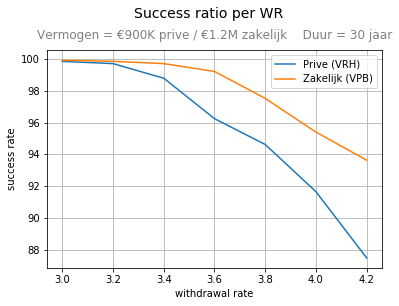

In [25]:
ax = results_30y_1200k.rename({('success rate', 'vermogensbelasting 2018'): 'foo'}).plot(grid=True)
plt.suptitle("Success ratio per WR", y=1.03, fontsize=14)
ax.set_ylabel("success rate")
ax.legend(["Prive (VRH)", "Zakelijk (VPB)"]);
plt.title("Vermogen = €900K prive / €1.2M zakelijk    Duur = 30 jaar", fontsize=12, y=1.025,  color='grey')

In [19]:
capital = 1200000 # initial capital
duration = 40 # years
withdrawal_rates = [3, 3.2, 3.4, 3.6, 3.8, 4]

results = pd.DataFrame(index=withdrawal_rates)
for wr in results.index:
    run = simulate(capital*0.75, wr/100, duration, vermogensbelasting_2018)
    results.at[wr, 'vermogensbelasting 2018'] = success_rate(run) * 100
    
    run = simulate(capital, wr/100, duration, vennootschapsbelasting)
    results.at[wr, 'vennootschapsbelasting 2018'] = success_rate(run) * 100
    
results_40y_1200k = results

In [22]:
results_40y_1200k

,vermogensbelasting 2018,vennootschapsbelasting 2018
3.0,99.690881,99.768161
3.2,98.299845,99.690881
3.4,94.976816,99.304482
3.6,91.421947,98.222566
3.8,84.930448,95.440495
4.0,80.525502,92.272025


Text(0.5, 1.02, 'Vermogen: €1.2M   Duur: 40 jaar')

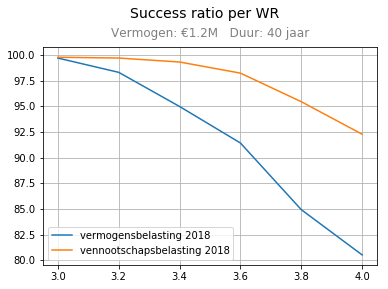

In [21]:
results_40y_1200k.plot(grid=True)
plt.suptitle("Success ratio per WR", y=1.02, fontsize=14)
plt.title("Vermogen: €900K / €1.2M   Duur: 40 jaar", fontsize=12, y=1.02, color='grey')

In [8]:
capital = 300000 # initial capital
duration = 15 # years
withdrawal_rates = [ 4, 4.4, 4.8, 5.2, 5.6, 6]

def run(capital, wr, duration):
    run = simulate(capital, wr/100, duration)
    capital_infl_adjusted = capital * pow(1.02, duration)
    return [success_rate(run) * 100, success_rate(run, capital_infl_adjusted) * 100]

data = {}
for wr in withdrawal_rates:
    results = run(capital, wr, duration)
    data[wr] = { 
        '> 0': results[0], 
        '> 100%': results[1],
    }

results = pd.DataFrame(data)
results_15y_300k = results

In [9]:
results_15y_300k

,4.0,4.4,4.8,5.2,5.6,6.0
> 0,100.00000,99.937265,99.749059,99.560853,97.490590,94.102886
> 100%,74.34128,68.381430,63.550816,59.410289,54.328733,49.435383


Text(0.5, 1.02, 'Vermogen: €300K  Duur: 15 jaar')

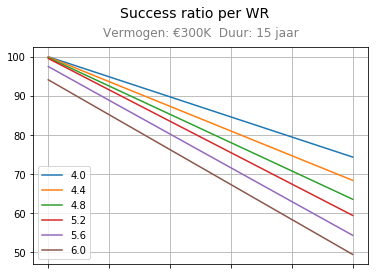

In [13]:
results_15y_300k.plot(grid=True)
plt.suptitle("Success ratio per WR", y=1.02, fontsize=14)
plt.title("Vermogen: €300K  Duur: 15 jaar", fontsize=12, y=1.02, color='grey')

In [15]:
capital = 1000000 # initial capital
duration = 30 # years
withdrawal_rates = [3.4, 3.6, 3.8, 4, 4.2, 4.4]

results = pd.DataFrame(index=withdrawal_rates)
for wr in results.index:
    run = simulate(capital, wr/100, duration, vermogensbelasting_2018)
    results.at[wr, 'vermogensbelasting 2018'] = success_rate(run) * 100
    
    run = simulate(capital, wr/100, duration, vermogensbelasting_rendement)
    results.at[wr, '30% over rendement'] = success_rate(run) * 100
    
results_30y_1000k_rendement = results

In [17]:
results_30y_1000k_rendement

,vermogensbelasting 2018,30% over rendement
3.4,98.800282,99.647142
3.6,96.189132,98.517996
3.8,94.565984,96.047989
4.0,91.601976,94.636556
4.2,87.367678,91.743119
4.4,82.992237,88.355681


Text(0.5, 0, 'Withdrawal rate')

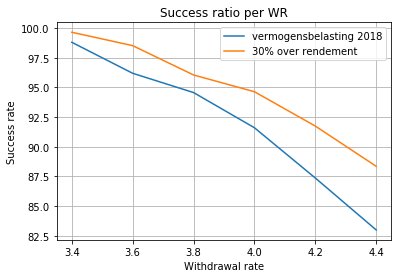

In [16]:
ax = results_30y_1000k_rendement.plot(grid=True, title="Success ratio per WR")
ax.set_ylabel("Success rate")
ax.set_xlabel("Withdrawal rate")
